In [1]:
from analysis.utils import module_reload
from analysis.plot_matplotlib import plot_hist
module_reload('iflow')
import iflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

debug = True

/root/miniforge3/envs/pytest/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from iflow.integration import integrator
from iflow.integration import couplings

def mask_flip(mask):
    """ Interchange 0 <-> 1 in the mask. """
    return 1-mask


def binary_list(inval, length):
    """ Convert x into a binary list of length l. """
    return np.array([int(i) for i in np.binary_repr(inval, length)])


def binary_masks(ndims):
    """ Create binary masks for to account for symmetries. """
    n_masks = int(np.ceil(np.log2(ndims)))
    sub_masks = np.transpose(np.array(
        [binary_list(i, n_masks)
         for i in range(ndims)]))[::-1]
    flip_masks = mask_flip(sub_masks)

    # Combine masks
    masks = np.empty((2*n_masks, ndims))
    masks[0::2] = flip_masks
    masks[1::2] = sub_masks

    return masks

In [3]:
n = 10
ndims = 4

samples = tf.linspace(0., 1., num=(n+1))[:-1]
samples = tf.expand_dims(samples, 0)
b = tf.constant([ndims,1], tf.int32)
samples = tf.tile(samples, b)

samples = tf.transpose(samples)
print(samples)

tf.Tensor(
[[0.         0.         0.         0.        ]
 [0.1        0.1        0.1        0.1       ]
 [0.2        0.2        0.2        0.2       ]
 [0.3        0.3        0.3        0.3       ]
 [0.4        0.4        0.4        0.4       ]
 [0.5        0.5        0.5        0.5       ]
 [0.6        0.6        0.6        0.6       ]
 [0.7        0.7        0.7        0.7       ]
 [0.8        0.8        0.8        0.8       ]
 [0.90000004 0.90000004 0.90000004 0.90000004]], shape=(10, 4), dtype=float32)


2024-03-24 21:29:23.158548: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-03-24 21:29:23.183025: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 21:29:23.183096: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce GTX 1070 Ti computeCapability: 6.1
coreClock: 1.683GHz coreCount: 19 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 238.66GiB/s
2024-03-24 21:29:23.183204: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/ILCSoft/LCIO/build/lib64
2024-03-24 21:29:23.183256: W tensorflow/stream_executor/platfo

In [4]:
from tensorflow_probability.python.internal import assert_util
from tensorflow_probability.python.internal import dtype_util
from tensorflow_probability.python.internal import tensor_util
from tensorflow_probability.python.internal import reparameterization
from tensorflow_probability.python.bijectors import sigmoid as sigmoid_bijector

class Uniform(tfd.Distribution):
  """Uniform distribution with `low` and `high` parameters.

  #### Mathematical Details

  The probability density function (pdf) is,

  ```none
  pdf(x; a, b) = I[a <= x < b] / Z
  Z = b - a
  ```

  where

  - `low = a`,
  - `high = b`,
  - `Z` is the normalizing constant, and
  - `I[predicate]` is the [indicator function](
    https://en.wikipedia.org/wiki/Indicator_function) for `predicate`.

  The parameters `low` and `high` must be shaped in a way that supports
  broadcasting (e.g., `high - low` is a valid operation).

  #### Examples

  ```python
  # Without broadcasting:
  u1 = Uniform(low=3.0, high=4.0)  # a single uniform distribution [3, 4]
  u2 = Uniform(low=[1.0, 2.0],
               high=[3.0, 4.0])  # 2 distributions [1, 3], [2, 4]
  u3 = Uniform(low=[[1.0, 2.0],
                    [3.0, 4.0]],
               high=[[1.5, 2.5],
                     [3.5, 4.5]])  # 4 distributions
  ```

  ```python
  # With broadcasting:
  u1 = Uniform(low=3.0, high=[5.0, 6.0, 7.0])  # 3 distributions
  ```

  """

  def __init__(self,
               low=0.,
               high=1.,
               validate_args=False,
               allow_nan_stats=True,
               name='Uniform',
               debug=debug):
    """Initialize a batch of Uniform distributions.

    Args:
      low: Floating point tensor, lower boundary of the output interval. Must
        have `low < high`.
      high: Floating point tensor, upper boundary of the output interval. Must
        have `low < high`.
      validate_args: Python `bool`, default `False`. When `True` distribution
        parameters are checked for validity despite possibly degrading runtime
        performance. When `False` invalid inputs may silently render incorrect
        outputs.
      allow_nan_stats: Python `bool`, default `True`. When `True`, statistics
        (e.g., mean, mode, variance) use the value "`NaN`" to indicate the
        result is undefined. When `False`, an exception is raised if one or
        more of the statistic's batch members are undefined.
      name: Python `str` name prefixed to Ops created by this class.

    Raises:
      InvalidArgumentError: if `low >= high` and `validate_args=False`.
    """
    parameters = dict(locals())
    with tf.name_scope(name) as name:
      dtype = dtype_util.common_dtype([low, high], tf.float32)
      self._low = tensor_util.convert_nonref_to_tensor(
          low, name='low', dtype=dtype)
      self._high = tensor_util.convert_nonref_to_tensor(
          high, name='high', dtype=dtype)
      self._ndims = len(low)
      
      super(Uniform, self).__init__(
          dtype=dtype,
          reparameterization_type=reparameterization.FULLY_REPARAMETERIZED,
          validate_args=validate_args,
          allow_nan_stats=allow_nan_stats,
          parameters=parameters,
          name=name)
      
      self.debug = debug

  @staticmethod
  def _param_shapes(sample_shape):
    return dict(
        zip(('low', 'high'),
            ([tf.convert_to_tensor(sample_shape, dtype=tf.int32)] * 2)))

  @classmethod
  def _params_event_ndims(cls):
    return dict(low=0, high=0)

  @property
  def low(self):
    """Lower boundary of the output interval."""
    return self._low

  @property
  def high(self):
    """Upper boundary of the output interval."""
    return self._high

  def range(self, name='range'):
    """`high - low`."""
    with self._name_and_control_scope(name):
      return self._range()

  def _range(self, low=None, high=None):
    low = self.low if low is None else low
    high = self.high if high is None else high
    return high - low

  def _batch_shape_tensor(self, low=None, high=None):
    return tf.broadcast_dynamic_shape(
        tf.shape(self.low if low is None else low),
        tf.shape(self.high if high is None else high))

  def _batch_shape(self):
    return tf.broadcast_static_shape(
        self.low.shape,
        self.high.shape)

  def _event_shape_tensor(self):
    return tf.constant([], dtype=tf.int32)

  def _event_shape(self):
    return tf.TensorShape([])

  def _sample_n(self, n, seed=None):
    low = tf.convert_to_tensor(self.low)
    high = tf.convert_to_tensor(self.high)
    shape = tf.concat([[n], self._batch_shape_tensor(low=low, high=high)], 0)
    if self.debug:
      samples = tf.linspace(0., 1., num=(n+1))[:-1]
      samples = tf.expand_dims(samples, 0)
      b = tf.constant([self._ndims,1], tf.int32)
      samples = tf.tile(samples, b)

      samples = tf.transpose(samples)
      samples = tf.cast(samples, self.dtype)
      print(f'Sampled between [{samples[0][0]}] [{samples[-1][0]}]')
    else:
      samples = tf.random.uniform(shape=shape, dtype=self.dtype, seed=seed)

    return low + self._range(low=low, high=high) * samples

  def _prob(self, x):
    low = tf.convert_to_tensor(self.low)
    high = tf.convert_to_tensor(self.high)
    return tf.where(
        tf.math.is_nan(x),
        x,
        tf.where(
            # This > is only sound for continuous uniform
            (x < low) | (x > high),
            tf.zeros_like(x),
            tf.ones_like(x) / self._range(low=low, high=high)))

  def _cdf(self, x):
    low = tf.convert_to_tensor(self.low)
    high = tf.convert_to_tensor(self.high)
    broadcast_shape = tf.broadcast_dynamic_shape(
        tf.shape(x), self._batch_shape_tensor(low=low, high=high))
    zeros = tf.zeros(broadcast_shape, dtype=self.dtype)
    ones = tf.ones(broadcast_shape, dtype=self.dtype)
    result_if_not_big = tf.where(x < low, zeros,
                                 (x - low) / self._range(low=low, high=high))
    return tf.where(x >= high, ones, result_if_not_big)

  def _quantile(self, value):
    return (1. - value) * self.low + value * self.high

  def _entropy(self):
    return tf.math.log(self._range())

  def _mean(self):
    return (self.low + self.high) / 2.

  def _variance(self):
    return tf.square(self._range()) / 12.

  def _stddev(self):
    return self._range() / np.sqrt(12.)

  def _default_event_space_bijector(self):
    return sigmoid_bijector.Sigmoid(
        low=self.low, high=self.high, validate_args=self.validate_args)

  def _parameter_control_dependencies(self, is_init):
    if not self.validate_args:
      return []
    assertions = []
    low = None
    high = None
    if is_init != tensor_util.is_ref(self.low):
      low = tf.convert_to_tensor(self.low)
      high = tf.convert_to_tensor(self.high)
      assertions.append(assert_util.assert_less(
          low, high, message='uniform not defined when `low` >= `high`.'))
    if is_init != tensor_util.is_ref(self.high):
      low = tf.convert_to_tensor(self.low) if low is None else low
      high = tf.convert_to_tensor(self.high) if high is None else high
      assertions.append(assert_util.assert_less(
          low, high, message='uniform not defined when `low` >= `high`.'))
    return assertions

  def _sample_control_dependencies(self, x):
    assertions = []
    if not self.validate_args:
      return assertions
    assertions.append(assert_util.assert_greater_equal(
        x, self.low, message='Sample must be greater than or equal to `low`.'))
    assertions.append(assert_util.assert_less_equal(
        x, self.high, message='Sample must be less than or equal to `high`.'))
    return assertions

In [5]:
def build_iflow(func, ndims, debug=debug):
    """ Build the iflow integrator

    Args:
        func: integrand
        ndims (int): dimensionality of the integrand

    Returns: Integrator: iflow Integrator object

    """
    masks = binary_masks(ndims)
    bijector = []
    i = 0
    for mask in masks:
        bijector.append(couplings.PiecewiseRationalQuadratic(mask, build,
                                                             num_bins=16,
                                                             blob=None,
                                                             options=None))
        i += 1
        
    bijector = tfb.Chain(list(reversed(bijector)))
    low = np.zeros(ndims, dtype=np.float64)
    high = np.ones(ndims, dtype=np.float64)
    dist = Uniform(low=low, high=high, debug=debug)
    dist = tfd.Independent(distribution=dist,
                           reinterpreted_batch_ndims=1)
    dist = tfd.TransformedDistribution(
        distribution=dist,
        bijector=bijector)

    optimizer = tf.keras.optimizers.Adam(1e-3, clipnorm=10.0)
    integrate = integrator.Integrator(func, dist, optimizer,
                                      loss_func='exponential')

    return integrate

def train_iflow(integrate, ptspepoch, epochs, test_callback=None):
    """ Run the iflow integrator

    Args:
        integrate (Integrator): iflow Integrator class object
        ptspepoch (int): number of points per epoch in training
        epochs (int): number of epochs for training

    Returns:
        numpy.ndarray(float): value of loss (mean) and its uncertainty (standard deviation)

    """
    means = np.zeros(epochs)
    stddevs = np.zeros(epochs)
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        loss, integral, error = integrate.train_one_step(ptspepoch, integral=True)
        means[epoch] = integral
        stddevs[epoch] = error
        losses[epoch] = loss
        _, current_precision = variance_weighted_result(means[:epoch+1], stddevs[:epoch+1])
        if epoch % 10 == 0:
            print('Epoch: {:3d} Loss = {:8e} Integral = '
                  '{:8e} +/- {:8e} Total uncertainty = {:8e}'.format(epoch, loss,
                                                                     integral, error,
                                                                     current_precision))
            
            if test_callback is not None:
                test_callback(integrate)

    return means, stddevs, losses

def variance_weighted_result(means, stddevs):
    """ Computes weighted mean and stddev of given means and
        stddevs arrays, using Inverse-variance weighting
    """
    assert np.size(means) == np.size(stddevs)
    assert means.shape == stddevs.shape
    variance = 1./np.sum(1./stddevs**2, axis=-1)
    mean = np.sum(means/(stddevs**2), axis=-1)
    mean *= variance
    return mean, np.sqrt(variance)

def build(in_features, out_features, options, init_debug=debug):
    """ Builds a dense NN.

    The output layer is initialized to 0, so the first pass
    before training gives the identity transformation.

    Arguments:
        in_features (int): dimensionality of the inputs space
        out_features (int): dimensionality of the output space
        options: additional arguments, not used at the moment

    Returns:
        A tf.keras.models.Model instance

    """
    del options
    
    bias_initializer = tf.constant_initializer(value=0.01) if init_debug else None
    kernel_initializer = tf.constant_initializer(value=0.01) if init_debug else None

    invals = tf.keras.layers.Input(in_features, dtype=tf.float64)
    hidden = tf.keras.layers.Dense(32, activation='relu', bias_initializer=bias_initializer, kernel_initializer=kernel_initializer)(invals)
    hidden = tf.keras.layers.Dense(32, activation='relu', bias_initializer=bias_initializer, kernel_initializer=kernel_initializer)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu', bias_initializer=bias_initializer, kernel_initializer=kernel_initializer)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu', bias_initializer=bias_initializer, kernel_initializer=kernel_initializer)(hidden)
    outputs = tf.keras.layers.Dense(out_features, bias_initializer='zeros',
                                    kernel_initializer='zeros')(hidden)
    model = tf.keras.models.Model(invals, outputs)
    model.summary()
    return model

In [6]:
def camel(x, alpha:float=0.2, ndims:int=4):
    """ Based on eq. 17 of [1], Camel function.

    The Camel function consists of two Gaussians, centered at
    (1/3, 2/3) in each dimension.

    Integral equals
        (0.5*(erf(1/(3*alpha)) + erf(2/(3*alpha)) ))** ndims

    Args:
        x (tf.Tensor): Tensor with batch of points to evaluate

    Returns: tf.Tensor: functional values at the given points

    """
    pre = tf.cast(1./(alpha*tf.sqrt(np.pi))**ndims,
                    dtype=tf.float64)
    exponent1 = -1.*tf.reduce_sum(((x-(1./3.))**2)/alpha**2, axis=-1)
    exponent2 = -1.*tf.reduce_sum(((x-(2./3.))**2)/alpha**2, axis=-1)

    return 0.5*pre*(tf.exp(exponent1)+tf.exp(exponent2))
    
def plot_proposal(integrate, n_samples:int=10000, is_dist:bool=False):
    if is_dist:
        samples = integrate.sample(n_samples).numpy()
    else:
        samples = integrate.dist.sample(n_samples).numpy()
    
    all_max = np.max(samples).max()
    all_min = np.min(samples).min()
    dfbase = {}
    for i in range(len(samples.T)):
        dfbase[f'x{i}'] = samples.T[i]

    plot_hist(pd.DataFrame(dfbase), normalize=True, xlim=(all_min, all_max), xlim_binning=(all_min, all_max))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 98)                3234      
Total params: 6,498
Trainable params: 6,498
Non-trainable params: 0
___________________________________________________________

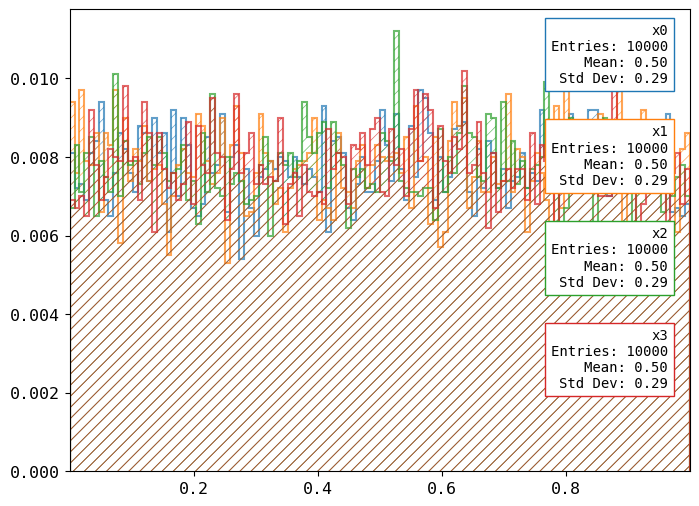

In [7]:
tf.keras.backend.set_floatx('float64')
integrate = build_iflow(camel, 4, debug=False)
plot_proposal(integrate)

2024-03-24 21:29:25.205632: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


indices [1 3 0 2]
indices [0 2 1 3]
indices [2 3 0 1]
indices [0 1 2 3]
Epoch:   0 Loss = 4.000927e+00 Integral = 9.414724e-01 +/- 3.571317e-02 Total uncertainty = 3.571317e-02
indices [1 3 0 2]
indices [0 2 1 3]
indices [2 3 0 1]
indices [0 1 2 3]
indices [1 3 0 2]
indices [0 2 1 3]
indices [2 3 0 1]
indices [0 1 2 3]
indices [1 3 0 2]
indices [0 2 1 3]
indices [2 3 0 1]
indices [0 1 2 3]
indices [1 3 0 2]
indices [0 2 1 3]
indices [2 3 0 1]
indices [0 1 2 3]
indices [1 3 0 2]
indices [0 2 1 3]
indices [2 3 0 1]
indices [0 1 2 3]
indices [1 3 0 2]
indices [0 2 1 3]
indices [2 3 0 1]
indices [0 1 2 3]
indices [1 3 0 2]
indices [0 2 1 3]
indices [2 3 0 1]
indices [0 1 2 3]
indices [1 3 0 2]
indices [0 2 1 3]
indices [2 3 0 1]
indices [0 1 2 3]
indices [1 3 0 2]
indices [0 2 1 3]
indices [2 3 0 1]
indices [0 1 2 3]
indices [1 3 0 2]
indices [0 2 1 3]
indices [2 3 0 1]
indices [0 1 2 3]
indices [1 3 0 2]
indices [0 2 1 3]
indices [2 3 0 1]
indices [0 1 2 3]
Epoch:  10 Loss = 3.663588e+00 

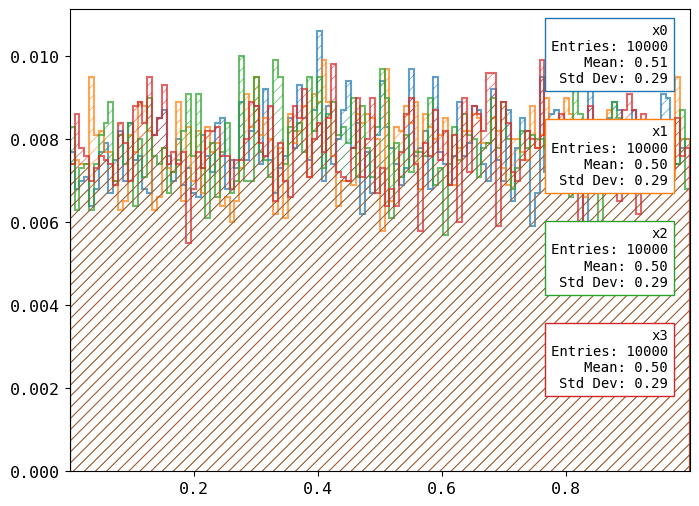

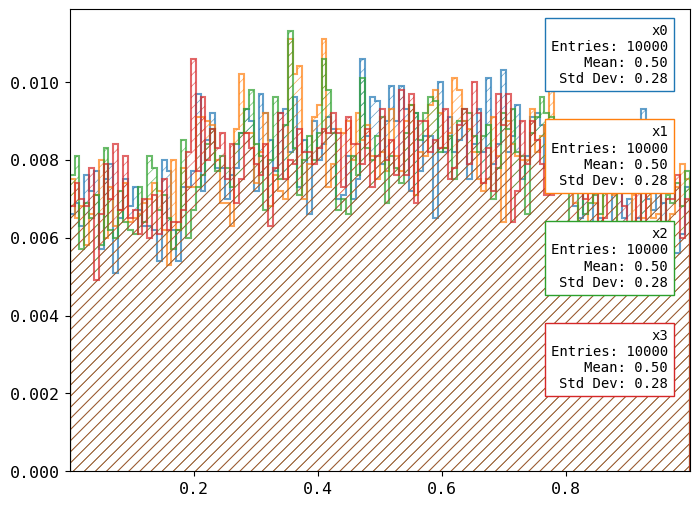

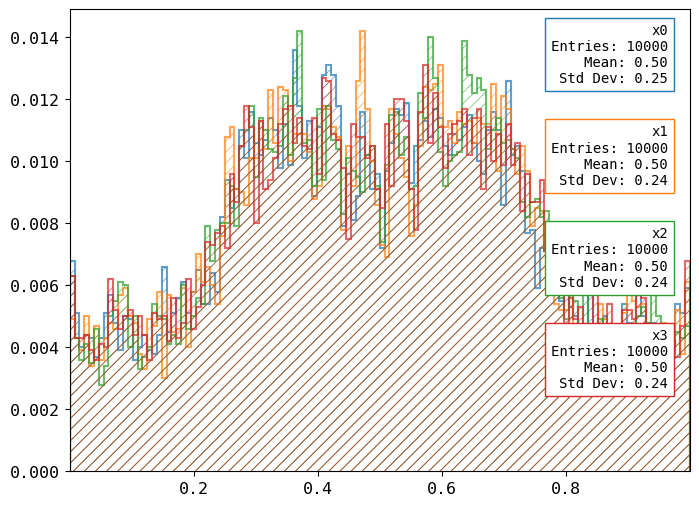

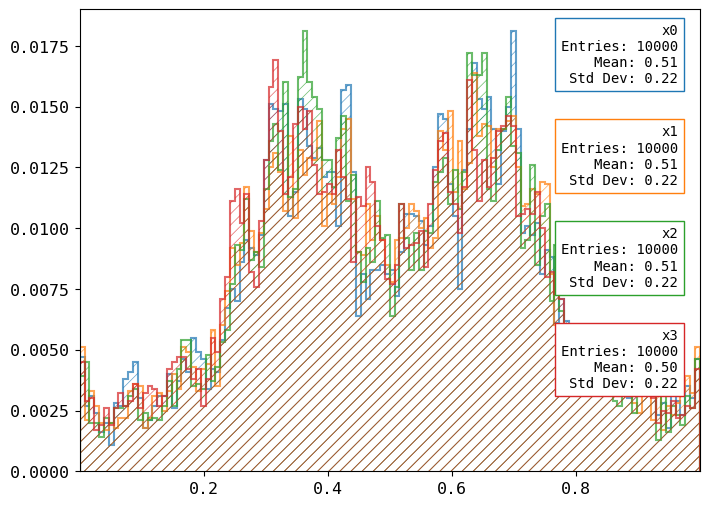

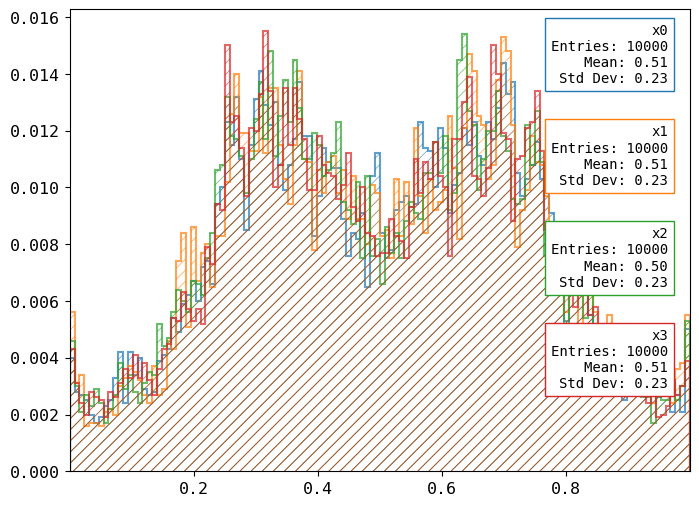

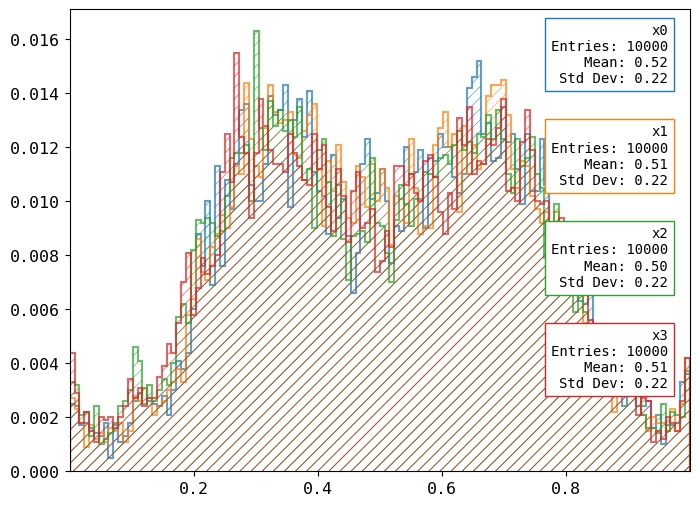

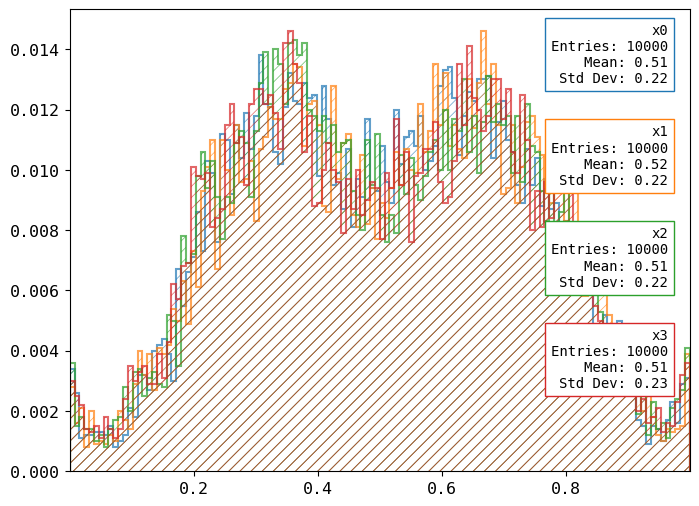

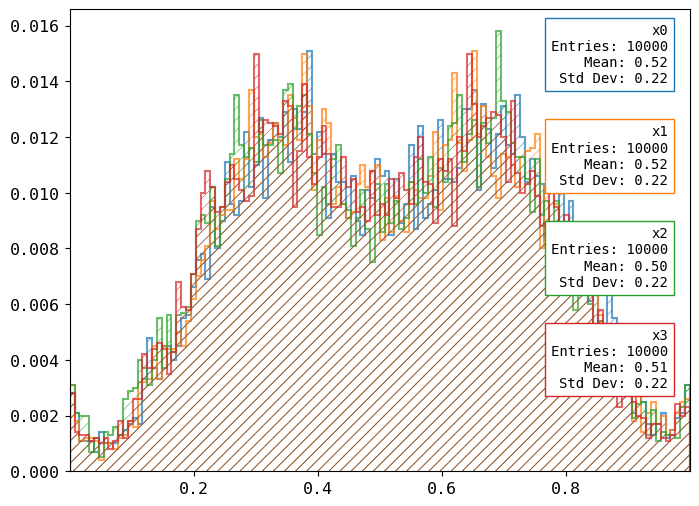

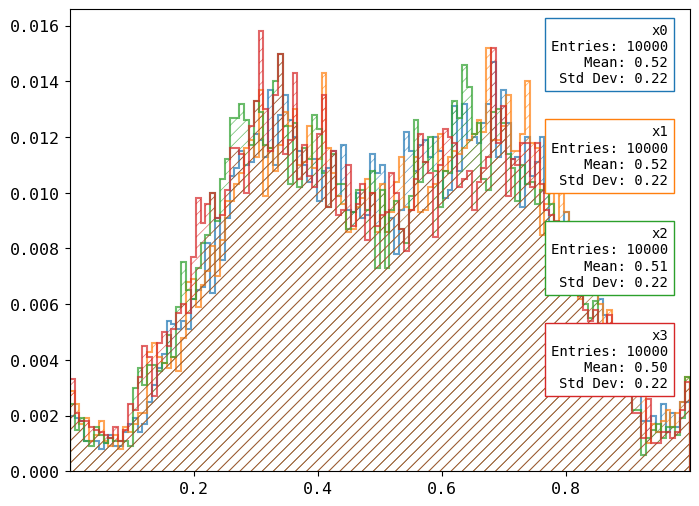

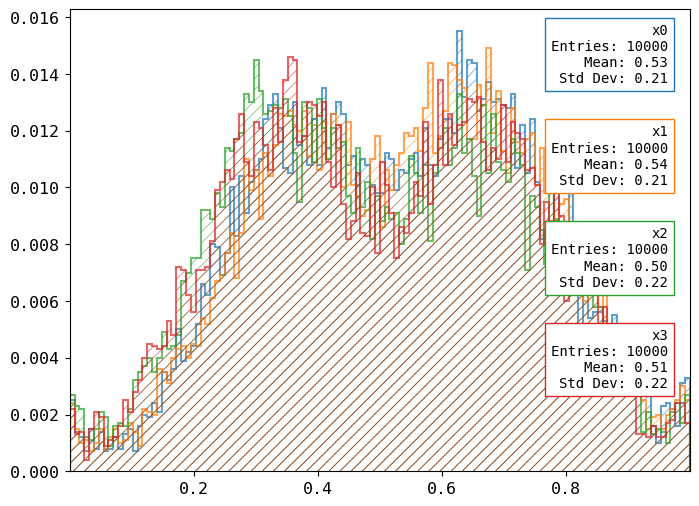

In [8]:
means, stddevs, losses = train_iflow(integrate, 5000, 300, plot_proposal)
#plot_proposal(integrate)

In [59]:
integrate.dist.bijector.bijectors[3].identity_features.numpy()

array([1, 3], dtype=int32)

In [78]:
def export_to_torch(integrate):
    tot = 0
    weight_dict = {}
    i = 0
    n_tot = len(integrate.dist.bijector.bijectors)

    for bj in integrate.dist.bijector.bijectors:
        ci = n_tot -1 - i
        #print(bj, bj.identity_features.numpy())
        for subm in reversed(bj.submodules):
            if isinstance(subm, tf.keras.Model):
                subm_weights = subm.get_weights()
                print(subm, len(subm_weights))
                
                n_hidden = int((len(subm_weights)-2)/2)
                for j in range(n_hidden):
                    weight_dict[f'flows.{ci}.transform_net.hidden_layers.{j*2}.weight'] = subm_weights[j*2]
                    weight_dict[f'flows.{ci}.transform_net.hidden_layers.{j*2}.bias'] = subm_weights[j*2+1]
                
                weight_dict[f'flows.{ci}.transform_net.final_layer.weight'] = subm_weights[-2]
                weight_dict[f'flows.{ci}.transform_net.final_layer.bias'] = subm_weights[-1]
                
                
                #print(subm, n_hidden)
                #(len(subm.get_weights()))
                #weights, biases = subm.get_weights()
                
                for weights in subm_weights:
                    tot += np.prod(weights.shape)
                #    print(weights.shape)
                    
        i += 1
        
    print(tot)
    
    return weight_dict

In [79]:
np.save('/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/analysis/nis/model_params_tfp.npy', export_to_torch(integrate), allow_pickle=True)

<tensorflow.python.keras.engine.training.Model object at 0x7f5a38444250> 10
<tensorflow.python.keras.engine.training.Model object at 0x7f5a38496c10> 10
<tensorflow.python.keras.engine.training.Model object at 0x7f5a3846f3d0> 10
<tensorflow.python.keras.engine.training.Model object at 0x7f5a384b7f50> 10
25992


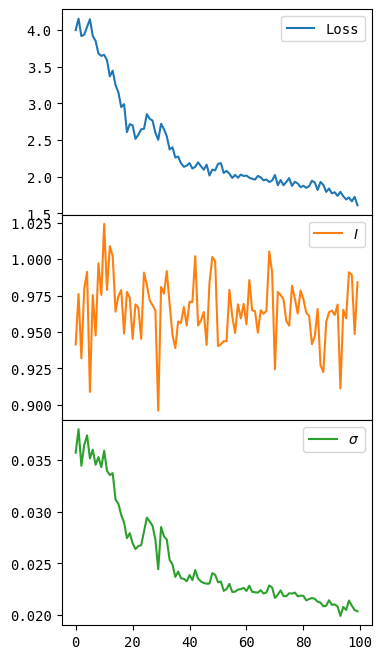

In [50]:
from analysis.plot_matplotlib import get_colorpalette

palette = get_colorpalette()
fig, ax = plt.subplots(3, 1, figsize=(4,8), gridspec_kw={'hspace': 0, 'wspace': 0})
ax[0].plot(np.arange(len(losses)), losses, label=r'Loss', color=palette[0])
ax[0].set_xlabel(r'Epoch')

ax[1].plot(np.arange(len(means)), means, label=r'$I$', color=palette[1])
ax[2].plot(np.arange(len(stddevs)), stddevs,label=r'$\sigma$', color=palette[2])

for i in range(len(ax)):
    ax[i].legend(loc='best')
    
#print(f'Estimate: {nis.evaluate()}')

indices [1 3 0 2]
indices [0 2 1 3]
indices [2 3 0 1]
indices [0 1 2 3]


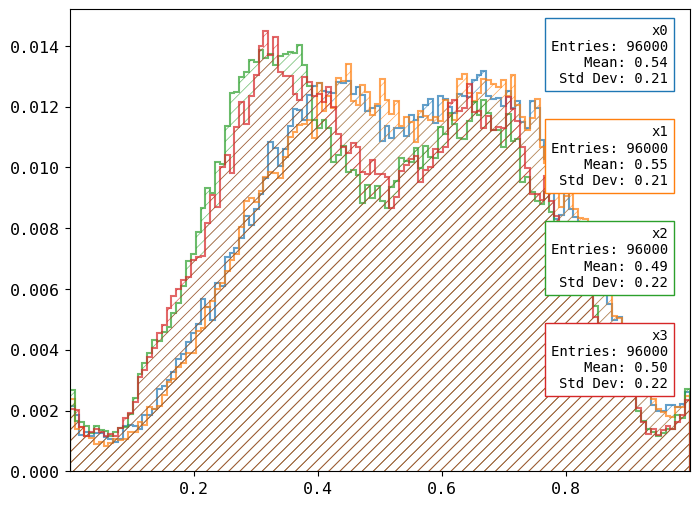

In [82]:
plot_proposal(integrate, n_samples=96000)

In [28]:
def evaluate_iflow(nsamples:int, integrate:iflow.integration.Integrator):
    samples = integrate.sample(nsamples)
    
    true = tf.abs(integrate._func(samples))
    test = integrate.dist.prob(samples)
    
    mean, var = tf.nn.moments(x=true/test, axes=[0])
    stddev = tf.sqrt(var/(nsamples-1.))
    
    return mean.numpy(), stddev.numpy()    

In [36]:
from tqdm.auto import tqdm

In [37]:
n_samples = 200
r_means = np.zeros(n_samples, dtype=float)
r_stddevs = np.zeros(n_samples, dtype=float)

for i in tqdm(range(n_samples)):
    mean, stddev = evaluate_iflow(5000, integrate)
    r_means[i] = mean
    r_stddevs[i] = stddev

100%|██████████| 200/200 [01:07<00:00,  2.97it/s]


(array([ 2.,  2., 14., 38., 33., 44., 38., 13.,  8.,  8.]),
 array([0.90510626, 0.91650733, 0.92790841, 0.93930948, 0.95071055,
        0.96211163, 0.9735127 , 0.98491378, 0.99631485, 1.00771592,
        1.019117  ]),
 <BarContainer object of 10 artists>)

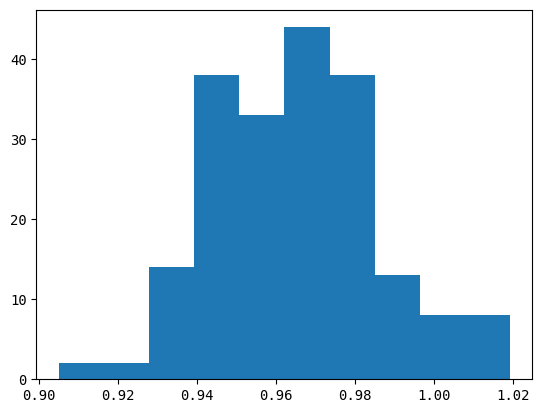

In [39]:
plt.hist(r_means)

(array([ 8., 24., 43., 46., 40., 19., 15.,  3.,  1.,  1.]),
 array([0.01884123, 0.01910514, 0.01936904, 0.01963294, 0.01989684,
        0.02016074, 0.02042464, 0.02068854, 0.02095244, 0.02121635,
        0.02148025]),
 <BarContainer object of 10 artists>)

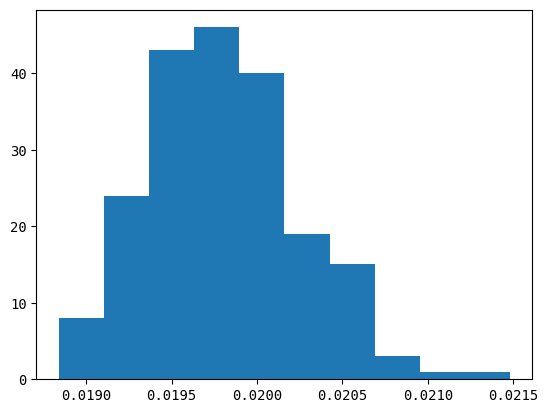

In [41]:
plt.hist(r_stddevs)

In [13]:
integrate.sample(100)

<tf.Tensor: shape=(100, 4), dtype=float64, numpy=
array([[0.81901066, 0.19495294, 0.50420347, 0.63760019],
       [0.25339554, 0.68212297, 0.54565291, 0.2705277 ],
       [0.57520584, 0.71610453, 0.77060534, 0.64220275],
       [0.65520925, 0.62189097, 0.64625198, 0.62560523],
       [0.73729719, 0.00181019, 0.60649911, 0.56761956],
       [0.53788197, 0.03582955, 0.15771409, 0.28545283],
       [0.45042515, 0.58923128, 0.99206322, 0.53479553],
       [0.91798173, 0.79971235, 0.23110666, 0.29373301],
       [0.5688441 , 0.84946069, 0.70190802, 0.5378865 ],
       [0.56520866, 0.46683697, 0.47453051, 0.40977246],
       [0.79401711, 0.84439328, 0.48579061, 0.20362488],
       [0.84881904, 0.20816348, 0.43121823, 0.7965123 ],
       [0.67678916, 0.52188007, 0.20851494, 0.31255545],
       [0.27297189, 0.71197239, 0.79933879, 0.21993351],
       [0.25486415, 0.42082255, 0.60359105, 0.70543906],
       [0.58507718, 0.81434053, 0.47579568, 0.62015167],
       [0.93925505, 0.62196722, 0.2326

Comparison to PyTorch implementation

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 98)                3234      
Total params: 6,498
Trainable params: 6,498
Non-trainable params: 0
___________________________________________________________

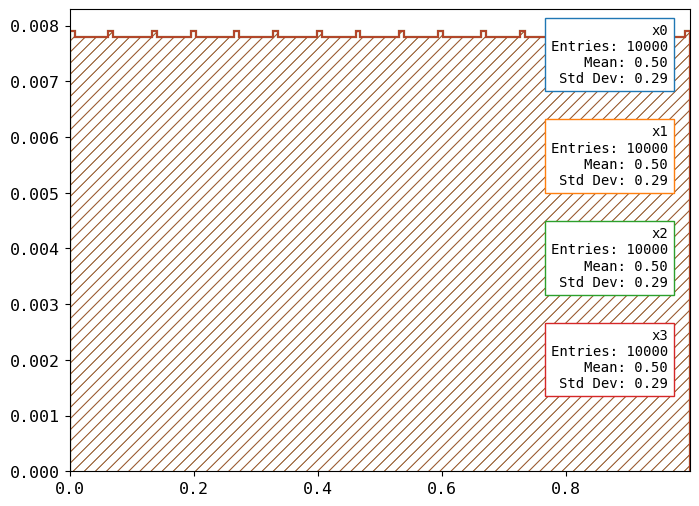

In [7]:
tf.keras.backend.set_floatx('float64')
integrate = build_iflow(camel, 4)
plot_proposal(integrate)

In [8]:
print(integrate.dist.bijector.trainable_variables)

(<tf.Variable 'dense_15/kernel:0' shape=(2, 32) dtype=float64, numpy=
array([[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]])>, <tf.Variable 'dense_15/bias:0' shape=(32,) dtype=float64, numpy=
array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])>, <tf.Variable 'dense_16/kernel:0' shape=(32, 32) dtype=float64, numpy=
array([[0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01,

2024-03-24 19:45:31.451452: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [10]:
a = integrate.dist.distribution.sample(2)
#print(a)
#print(integrate.dist.distribution.log_prob(a))
logp = integrate.dist.log_prob(a)
print('log_prob', logp.dtype, logp)

Sampled between [0.0] [0.5]
LOG PROB CALLED
Calling bijector.inverse
PiecewiseBijector[3] : INV
COUPL 3
INV [3] [5.495667706246729e-09 5.495667706246729e-09]
PiecewiseBijector[2] : INV
COUPL 2
INV [2] [5.495667706246729e-09 5.495667706246729e-09]
PiecewiseBijector[1] : INV
COUPL 1
INV [1] [5.495667706246729e-09 5.495667706246729e-09]
PiecewiseBijector[0] : INV
COUPL 0
INV [0] [5.495667706246729e-09 5.495667706246729e-09]
START Calling bijector.inverse_log_det_jacobian
START Chain
Iterating sub-bijectors [4]
START sub-bijector [0]
PiecewiseBijector[3] : INV
COUPL 3
INV [3] [5.495667706246729e-09 5.495667706246729e-09]
PiecewiseBijector[3] : INV
COUPL 3
INV [3] [5.495667706246729e-09 5.495667706246729e-09]
END sub-bijector [0]
START sub-bijector [1]
PiecewiseBijector[2] : INV
COUPL 2
INV [2] [5.495667706246729e-09 5.495667706246729e-09]
PiecewiseBijector[2] : INV
COUPL 2
INV [2] [5.495667706246729e-09 5.495667706246729e-09]
END sub-bijector [1]
START sub-bijector [2]
PiecewiseBijector[1]